In [2]:
import os
import argparse
import random
from utils import cfh, logger, Data, bool_ext, checkCorrelations, generate_masks_from_ppi
from biomodels import BioCitrus
import torch
import numpy as np
import sys
import pandas as pd

import warnings
warnings.filterwarnings("ignore") ##This is bad but temporary

device = 'cuda' if torch.cuda.is_available() else 'cpu'

if device == 'cuda':
    device_name = torch.cuda.get_device_name(0)
else:
    device_name = 'cpu'

parser = argparse.ArgumentParser()

parser.add_argument(
    "--input_dir", 
    help="directory of input files", 
    type=str, 
    default="./data"
)
parser.add_argument(
    "--output_dir",
    help="directory of output files",
    type=str,
    default="./output",
)

parser.add_argument(
    "--algo", 
    help="clustering algorithm to use on the portein-protein network (DPCLUS, MCODE, COACH)", 
    type=str, 
    default='COACH'
)

parser.add_argument(
    "--learning_rate", 
    help="learning rate for Adam", 
    type=float, 
    default=1e-2
)
parser.add_argument(
    "--max_iter", 
    help="maximum number of training iterations", 
    type=int, 
    default=100
)
parser.add_argument(
    "--max_fscore",
    help="Max F1 score to early stop model from training",
    type=float,
    default=0.7
)
parser.add_argument(
    "--batch_size", 
    help="training batch size", 
    type=int, 
    default=100
)
parser.add_argument(
    "--test_batch_size", 
    help="test batch size", 
    type=int, 
    default=100
)
parser.add_argument(
    "--test_inc_size",
    help="increment interval size between log outputs",
    type=int,
    default=64
)
parser.add_argument(
    "--dropout_rate", 
    help="dropout rate", 
    type=float, 
    default=0.1
)

parser.add_argument(
    "--weight_decay", 
    help="coefficient of l2 regularizer", 
    type=float, 
    default=1e-2
)
parser.add_argument(
    "--activation",
    help="activation function used in hidden layer",
    type=str,
    default="tanh",
)
parser.add_argument(
    "--patience", 
    help="earlystopping patience", 
    type=int, 
    default=5
)
parser.add_argument(
    "--mask01",
    help="wether to ignore the float value and convert mask to 01",
    type=bool_ext,
    default=True,
)
parser.add_argument(
    "--gep_normalization", 
    help="how to normalize gep", 
    type=str, 
    default="scaleRow"
)

parser.add_argument(
    "--cancer_type",
    help="whether to use cancer type or not",
    type=bool_ext,
    default=False,
)
parser.add_argument(
    "--train_model",
    help="whether to train model or load model",
    type=bool_ext,
    default=True,
)
parser.add_argument(
    "--dataset_name",
    help="the dataset name loaded and saved",
    type=str,
    default="dataset_CITRUS",
)
parser.add_argument(
    "--tag", 
    help="a tag passed from command line", 
    type=str, 
    default=""
)
parser.add_argument(
    "--run_count", 
    help="the count for training", 
    type=str, 
    default="1"
)

parser.add_argument(
    "--ppi_weights", 
    help="", 
    type=bool_ext, 
    default=False
)

parser.add_argument(
    "--verbose", 
    help="", 
    type=bool_ext, 
    default=False
)

parser.add_argument(
    "--constrain", 
    help="force weight and biases to be strictly non-negative", 
    type=bool_ext, 
    default=True
)

parser.add_argument(
    "--biases", 
    help="enable all nn.Linear biases", 
    type=bool_ext, 
    default=True
)

parser.add_argument(
    "--sparse", 
    help="only use SIGNOR data, resulting in sparser connections", 
    type=bool_ext, 
    default=False
)

parser.add_argument(
    "--cancer", 
    help="", 
    type=str, 
    default=''
)

with open('/ihome/hosmanbeyoglu/kor11/tools/CITRUS/COACH_clusters_large.txt', "r") as fh:
        lines = fh.readlines()
        clusterindex_to_genes = {}
        for i, c in enumerate(lines):
            clustlist = c.strip().split(" ")
            if len(c) == 0:
                continue
            clusterindex_to_genes[i] = clustlist 

from collections import defaultdict
gene_to_clusterindices = defaultdict(list) ## 'MAPK1':[0, 75, 129, 373]

## Create mapping between genes and the protein clusters
for c in clusterindex_to_genes.keys():
    for g in clusterindex_to_genes[c]:
        gene_to_clusterindices[g].append(c)  

_StoreAction(option_strings=['--cancer'], dest='cancer', nargs=None, const=None, default='', type=<class 'str'>, choices=None, help='', metavar=None)

In [4]:
args = parser.parse_args([])
if not os.path.exists(args.output_dir):
    os.makedirs(args.output_dir)
cancer_type = args.cancer
args.cancer_type = cancer_type
collected_metrics = []

In [88]:
data = Data(
    fGEP_SGA = 'data/CITRUS_GEP_SGAseparated.csv',
    fgene_tf_SGA = 'data/CITRUS_gene_tf_SGAseparated.csv',
    fcancerType_SGA = 'data/CITRUS_canType_SGAseparated.csv',
    fSGA_SGA = 'data/CITRUS_SGA_SGAseparated.csv',
    cancer_type = 'PRAD'
)
    
train_set, test_set = data.get_train_test()
args.gep_size = train_set['gep'].shape[1]
args.tf_gene = data.gene_tf_sga.values.T
args.can_size = len(np.unique(data.cancer_types))
args.sga_size = 11998


sga_mask, sga_weights, tf_mask, tf_weights = generate_masks_from_ppi(sga = data.sga_sga, tf = data.gene_tf_sga, clust_algo=args.algo, sparse=args.sparse)

sga_mask = sga_mask.to(device)
sga_weights = sga_weights.t().to(device)
tf_mask = tf_mask.t().to(device)
tf_weights = tf_weights.to(device)

if not args.ppi_weights:
    ppi_weights = None
    tf_weights = None


model = BioCitrus(
    args = args, 
    sga_ppi_mask = sga_mask, 
    ppi_tf_mask = tf_mask, 
    sga_ppi_weights = None, 
    ppi_tf_weights = None,
    enable_bias = args.biases
).to(device)

(utils.py : 371) -    DEBUG | Loaded 352251 edges from the SIGNOR and SNAP Networks
(utils.py : 395) -    DEBUG | Using induced overlap network with 10270 common genes
(utils.py : 489) -     INFO | Using dense COACH clustering algorithm
(utils.py : 550) -     INFO | Generated sga-ppi mask with 3862 clusters and 6533 edges
(utils.py : 569) -     INFO | Generated ppi-tf mask with 3862 clusters and 268 edges
(biomodels.py : 118) -    DEBUG | sga_layer.0.mask | False | (11998, 3862)
(biomodels.py : 118) -    DEBUG | sga_layer.0.weight | True | (11998, 3862)
(biomodels.py : 118) -    DEBUG | sga_layer.0.bias | True | (3862,)
(biomodels.py : 118) -    DEBUG | tf_layer.0.mask | False | (3862, 320)
(biomodels.py : 118) -    DEBUG | tf_layer.0.weight | True | (3862, 320)
(biomodels.py : 118) -    DEBUG | tf_layer.0.bias | True | (320,)
(biomodels.py : 118) -    DEBUG | gep_output_layer.weight | True | (320, 5541)
(biomodels.py : 118) -    DEBUG | gep_output_layer.bias | True | (5541,)
(biomodel

In [89]:
model.load_state_dict(torch.load(f'/ix/hosmanbeyoglu/kor11/CITRUS_models/embedded_model.pth', 
                                map_location=torch.device('cpu')))
    
model.eval();

In [90]:
from captum.attr import LayerConductance, LayerActivation, LayerIntegratedGradients
from captum.attr import IntegratedGradients

In [91]:
X = torch.tensor(test_set['sga'])
Y = test_set['gep']

In [92]:
lc = LayerConductance(model, model.sga_layer)
ix = list(data.gep_sga.columns).index('PIK3CA')
a = lc.attribute(X, n_steps=7, attribute_to_layer_input=True, target=[ix]*len(X))

ig_attr_test_sum = a.detach().cpu().numpy().sum(0)
ig_attr_test_norm_sum = ig_attr_test_sum / np.linalg.norm(ig_attr_test_sum, ord=1)

g = np.array(data.sga_sga.columns)
at = ig_attr_test_norm_sum

assert g.shape == at.shape

df = pd.DataFrame([g, at]).T
df.columns = ['label', 'score']
df.sort_values(by='score', ascending=False)[:10]
df.score = abs(df.score)

In [93]:
dff = pd.DataFrame(
    data.sga_sga.sum(0), columns = ['freq']).join(df.set_index('label')).sort_values(by='score', ascending=False)

In [107]:
data.sga_sga.sum(0).sort_values(ascending=False)

SM_PTEN          230
SM_PIK3CA        166
SM_ARID1A        149
SM_TP53          132
SM_TTN           120
                ... 
SCNA_OR5K4         0
SCNA_SERPINE3      0
SCNA_PCDHB4        0
SCNA_MORC1         0
SCNA_KIF6          0
Length: 11998, dtype: int64

In [94]:
import seaborn as sns
import matplotlib.pyplot as plt

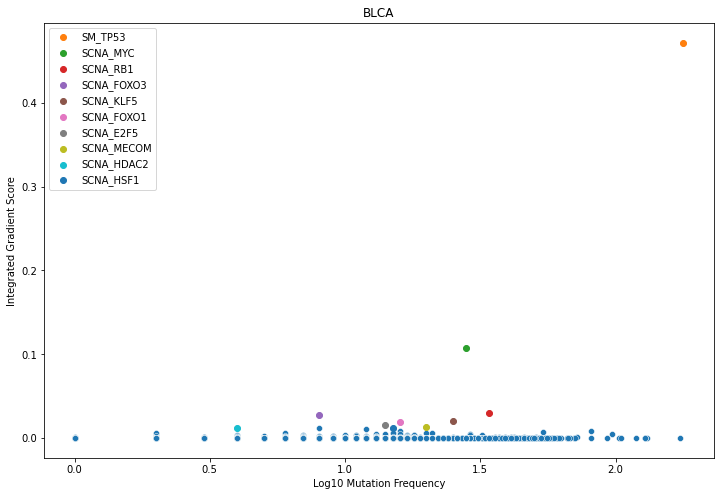

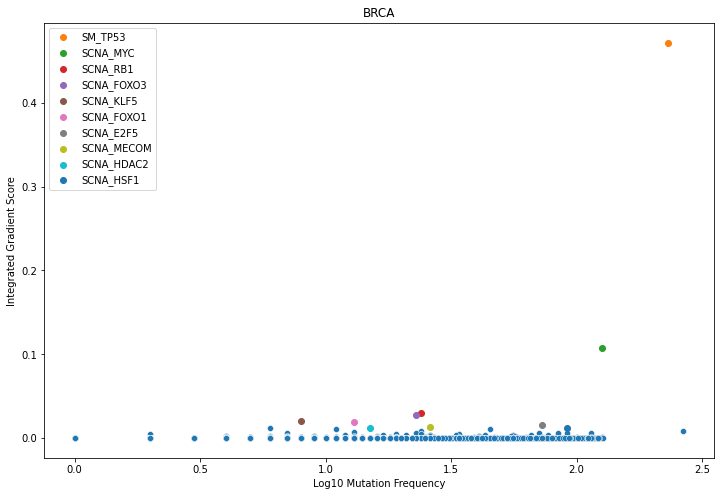

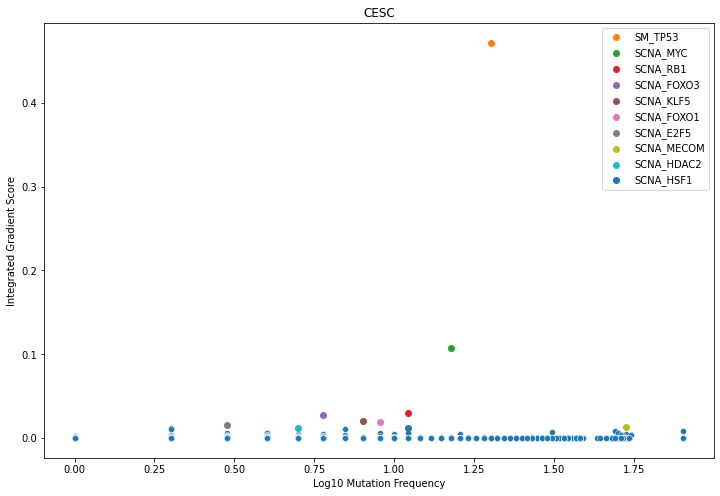

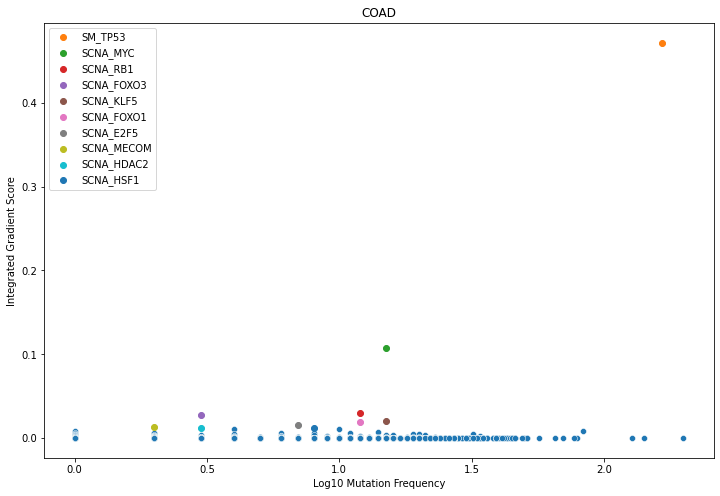

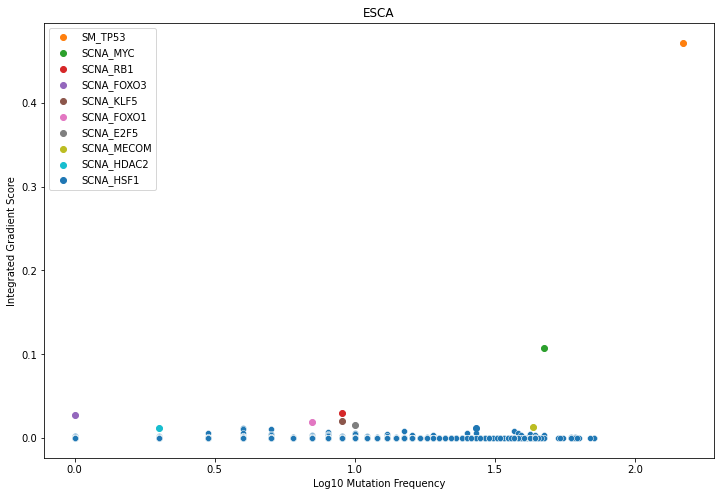

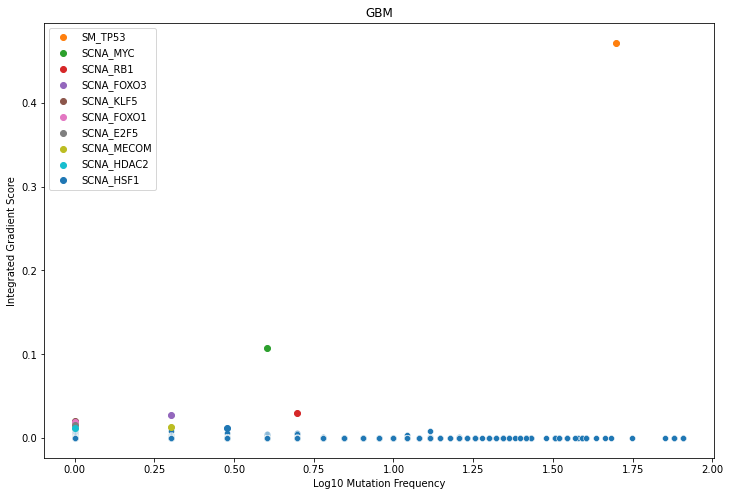

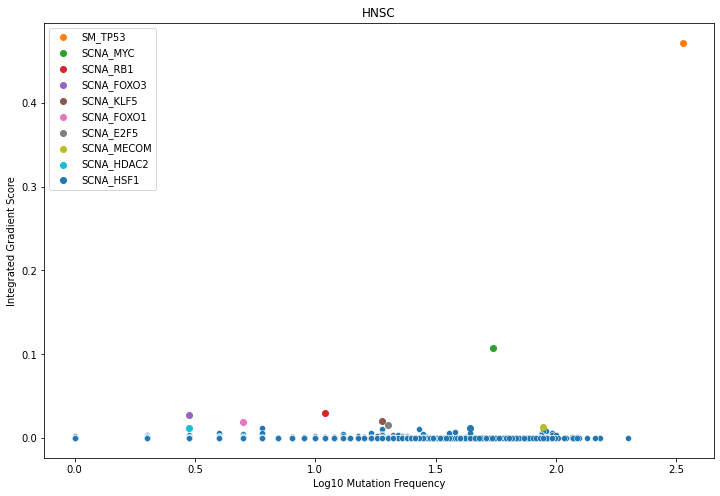

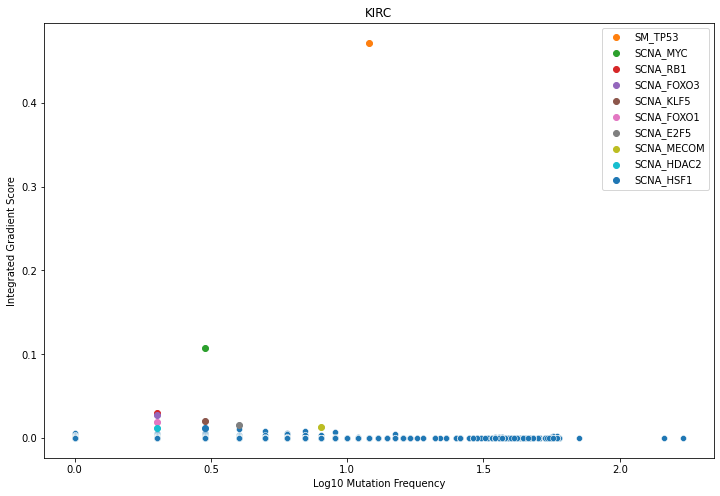

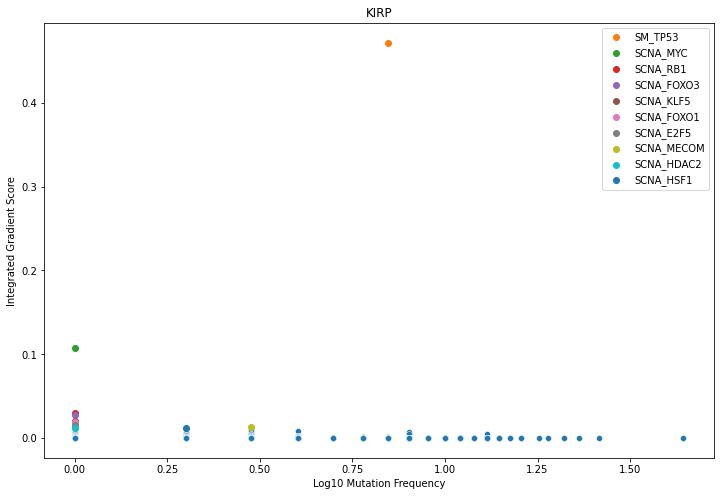

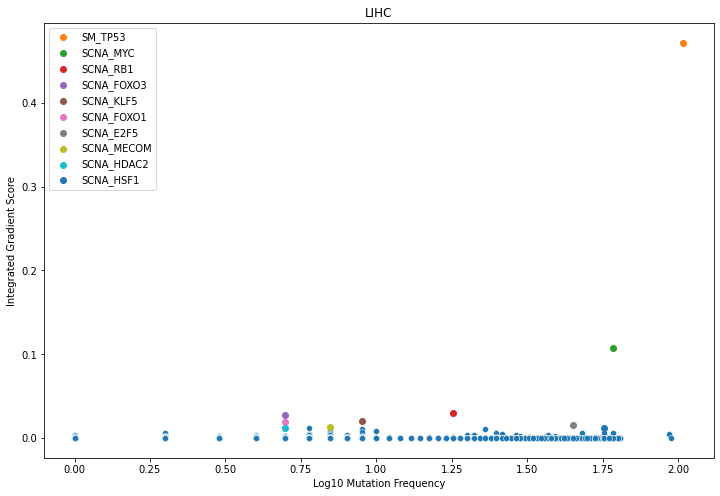

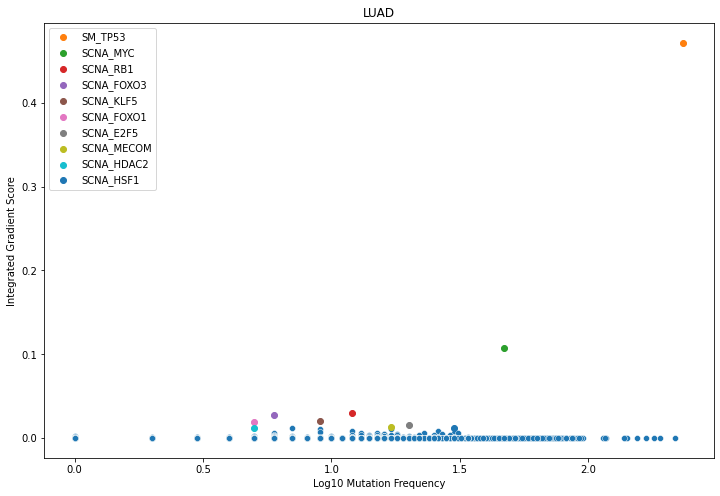

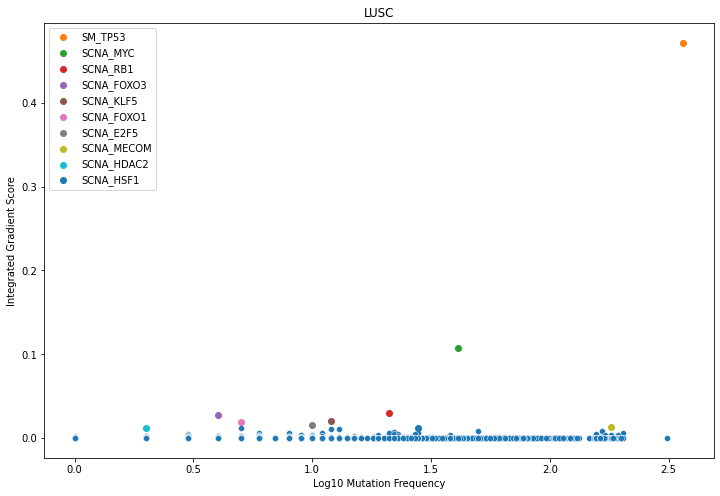

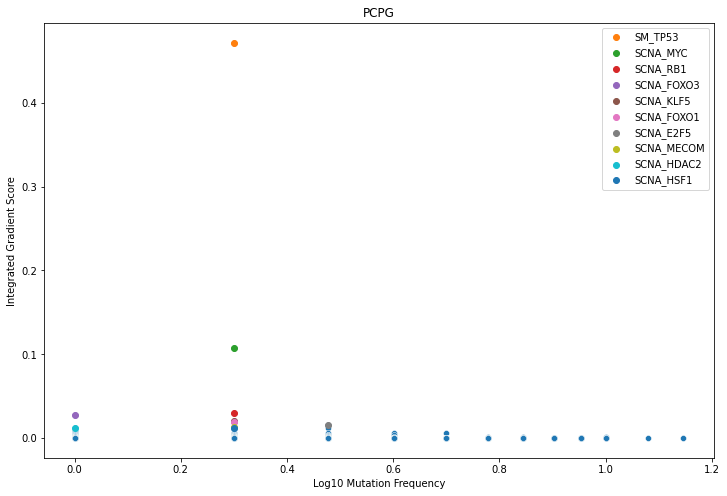

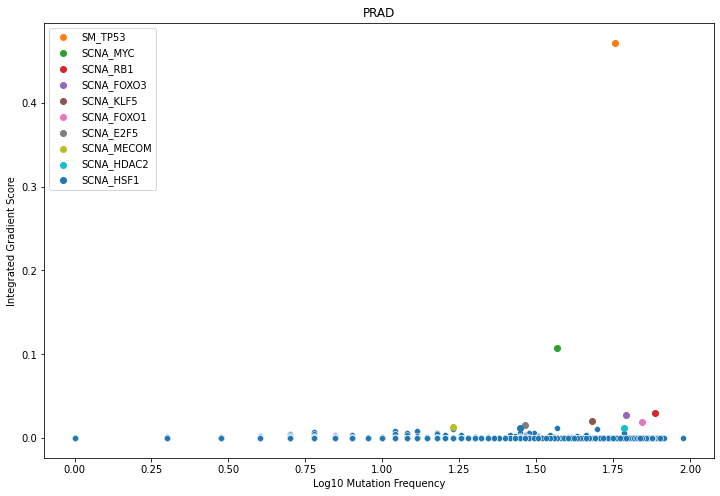

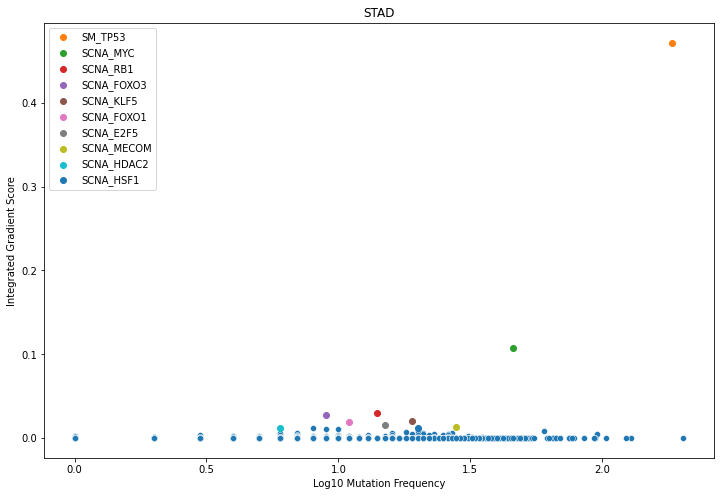

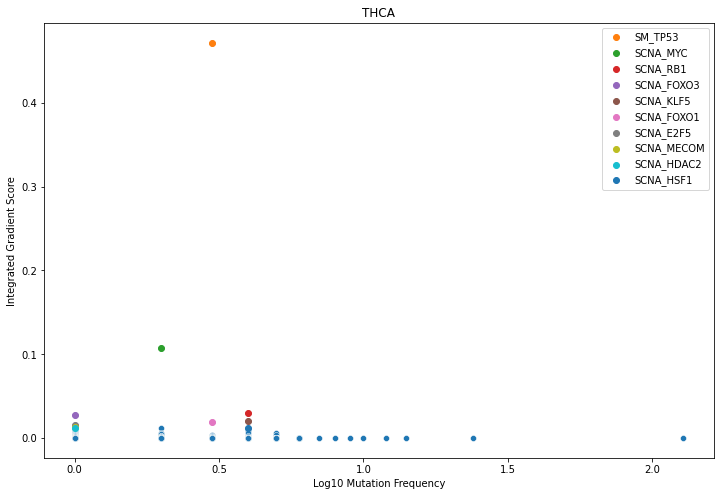

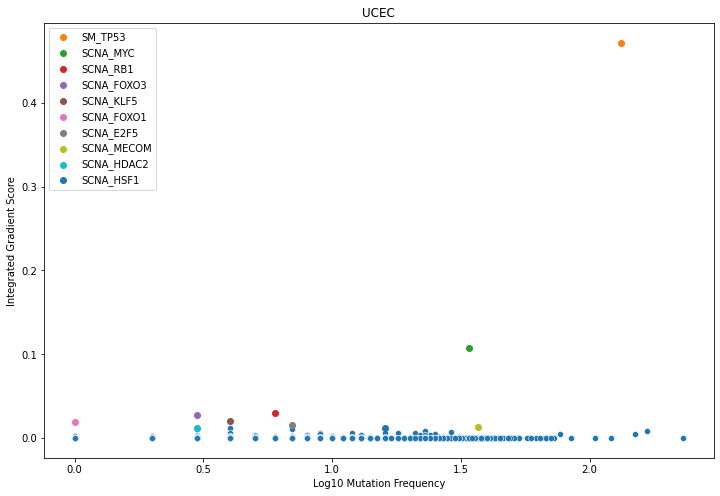

In [105]:
for cancer in ['BLCA', 'BRCA', 'CESC', 'COAD', 'ESCA', 'GBM', 'HNSC', 'KIRC',
       'KIRP', 'LIHC', 'LUAD', 'LUSC', 'PCPG', 'PRAD', 'STAD', 'THCA',
       'UCEC']:

    data = Data(
        fGEP_SGA = 'data/CITRUS_GEP_SGAseparated.csv',
        fgene_tf_SGA = 'data/CITRUS_gene_tf_SGAseparated.csv',
        fcancerType_SGA = 'data/CITRUS_canType_SGAseparated.csv',
        fSGA_SGA = 'data/CITRUS_SGA_SGAseparated.csv',
        cancer_type = cancer
    )
    
    X = torch.tensor(test_set['sga'])
    Y = test_set['gep']
    
    lc = LayerConductance(model, model.sga_layer)
    ix = list(data.gep_sga.columns).index('PIK3CA')
    a = lc.attribute(X, n_steps=7, attribute_to_layer_input=True, target=[ix]*len(X))

    ig_attr_test_sum = a.detach().cpu().numpy().sum(0)
    ig_attr_test_norm_sum = ig_attr_test_sum / np.linalg.norm(ig_attr_test_sum, ord=1)

    g = np.array(data.sga_sga.columns)
    at = ig_attr_test_norm_sum

    assert g.shape == at.shape
    

    df = pd.DataFrame([g, at]).T
    df.columns = ['label', 'score']
    df.sort_values(by='score', ascending=False)[:10]
    df.score = abs(df.score)
    
    dff = pd.DataFrame(
        data.sga_sga.sum(0), columns = ['freq']).join(df.set_index('label')).sort_values(by='score', ascending=False)

    
    plt.figure(figsize=(12, 8))
    plt.xlabel('Log10 Mutation Frequency')
    plt.ylabel('Integrated Gradient Score')
    plt.title(cancer)
    sns.scatterplot(np.log10(dff.freq+1), dff.score)
    for x in dff[:10].iterrows():
        label = x[0]
        f, s = x[1]
        plt.scatter(x=np.log10(f+1), y=s, label = label)
    plt.legend()
    plt.savefig(f'./plots/freq_plot_{cancer}.png', dpi=120)
    plt.show()

In [95]:
dff

,freq,score
SM_TP53,56,0.471944
SCNA_MYC,36,0.107881
SCNA_RB1,76,0.029558
SCNA_FOXO3,61,0.0271623
SCNA_KLF5,47,0.0206757
...,...,...
SCNA_HOXB3,5,0
SCNA_POLR3D,74,0
SCNA_TMEM199,6,0
SCNA_DMXL1,16,0


In [96]:
import requests
import json 
import pandas as pd

class Enrichr(object):
    
    def __init__(self):
        self.ENRICHR_URL_ADDLIST = 'https://maayanlab.cloud/Enrichr/addList'
        self.ENRICHR_URL = 'https://maayanlab.cloud/Enrichr/enrich'
        self.QUERY_STR = '?userListId=%s&backgroundType=%s'
        self.libraries = [
            'VirusMINT', 
            'GO_Biological_Process_2021', 
            'MSigDB_Hallmark_2020', 
            'KEGG_2021_Human', 
            'Reactome_2016']
        
    
    def _addlist(self, geneset):
        genes_str = '\n'.join(geneset)
        description = ''
        payload = {
            'list': (None, genes_str),
            'description': (None, description)
        }
        response = requests.post(self.ENRICHR_URL_ADDLIST, files=payload)
        data = json.loads(response.text)
        
        return data['userListId']
    
    def get_enrichment_results(self, geneset, gene_set_library = 'GO_Biological_Process_2021'):
        user_list_id = self._addlist(geneset)
        response = requests.get(
        self.ENRICHR_URL + self.QUERY_STR % (user_list_id, gene_set_library))
        data = json.loads(response.text)
        df = pd.DataFrame(data[gene_set_library])[[1, 2, 3, 4, 5, 6]]
        df.columns = ['Terms', 'Pval', 'OddsRatio', 'Score', 'Genes', 'AdjPval']
        
        return df[round(df.AdjPval, 3) < 0.05].sort_values(by='AdjPval')

In [97]:
enrichr = Enrichr()

In [76]:
[' | '.join(enrichr.get_enrichment_results(geneset=set(clusterindex_to_genes[i]), gene_set_library='KEGG_2021_Human').Terms[:2].values) 
        for i in np.where(model.sga_layer[0].mask[:, 211] == 1)[0]]

['T cell receptor signaling pathway | Natural killer cell mediated cytotoxicity',
 'Inflammatory mediator regulation of TRP channels | Insulin resistance',
 'ErbB signaling pathway | Chronic myeloid leukemia',
 'JAK-STAT signaling pathway | Pathways in cancer',
 'Pathways in cancer | Proteoglycans in cancer',
 'Focal adhesion | Neurotrophin signaling pathway',
 'ErbB signaling pathway | Renal cell carcinoma',
 'ErbB signaling pathway | Chronic myeloid leukemia',
 'Hepatitis C | Proteoglycans in cancer',
 'Thyroid hormone signaling pathway | Pathways in cancer',
 'Autophagy | Neurotrophin signaling pathway',
 'Pathways in cancer | Transcriptional misregulation in cancer',
 'Growth hormone synthesis, secretion and action | Insulin signaling pathway',
 'PI3K-Akt signaling pathway | MicroRNAs in cancer',
 'TNF signaling pathway | NF-kappa B signaling pathway',
 'Prostate cancer | PI3K-Akt signaling pathway',
 'Pathways in cancer | Thyroid hormone signaling pathway',
 'Insulin resistance | 

In [99]:
lc = LayerConductance(model, model.tf_layer)
ix = list(data.gep_sga.columns).index('PIK3CA')
a = lc.attribute(X, n_steps=7, attribute_to_layer_input=False, target=[ix]*len(X))

ig_attr_test_sum = a.detach().cpu().numpy().sum(0)
ig_attr_test_norm_sum = ig_attr_test_sum / np.linalg.norm(ig_attr_test_sum, ord=1)

g = np.array(data.gene_tf_sga.columns)
at = ig_attr_test_norm_sum

assert g.shape == at.shape

df = pd.DataFrame([g, at]).T
df.columns = ['label', 'score']

In [84]:
df.sort_values(by='score', ascending=False)[:20]

,label,score
256,SMARCC1,0.176973
309,E2F1,0.173729
49,FOXO1,0.155607
130,FOXO3,0.122811
143,RUNX2,0.0968519
235,ZEB1,0.0723333
42,SMARCC2,0.0548271
35,FOSL1,0.0308562
128,TCF12,0.0288102
153,FLI1,0.0228397
